# Linear Regression
[![Open In Colab](./images/colab.svg)](https://colab.research.google.com/github/dunnkers/linear-regression-to-neural-networks/blob/master/src/linear-regression.ipynb) 
[![Binder](./images/binder.svg)](https://mybinder.org/v2/gh/dunnkers/linear-regression-to-neural-networks/HEAD?filepath=src%2Flinear-regression.ipynb)

Notebook producing the figures in [Linear Regression to Neural Networks](https://dunnkers.com/linear-regression-to-neural-networks). Chapter on **Linear Regression**.

> For all source files, see [Github repository](https://github.com/dunnkers/linear-regression-to-neural-networks).

In [312]:
import seaborn as sns
import numpy as np
import pandas as pd
from enum import Enum
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from time import time
from tqdm.notebook import tqdm
from sklearn.linear_model import SGDRegressor
import tempfile
import shutil
%matplotlib inline
set_matplotlib_formats('svg')
!python --version

Python 3.9.2


## Dataset
First, we need some data. A simple dataset that still has enough complexity for our purposes is the **Penguin** [dataset](https://github.com/allisonhorst/penguins) from Antartica LTER ([Gorman et al. 2014](https://doi.org/10.1371/journal.pone.0090081)). Some scientists working in Antartica have measured the flipper length, body mass, nose depth and more of some penguins living there. The dataset includes three species.


In [2]:
data = sns.load_dataset('penguins')
data = data.dropna()
data.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

We can observe there are 4 quantitative columns describing the penguins. The penguin sex, island and species are categorical columns. The *bill* is the penguin's snout: we have variables `bill_depth_mm` and `bill_length_mm`.

![Penguin dimensions](images/penguin-dimensions.png)
<small class="caption">Penguin bill. Courtesy of @allison_horst.</small>

The other quantitative variables are the `flipper_length_mm` (length of penguin flipper in millimeters) and the `body_mass_g` (penguin body mass in grams).

Also, before conducting any experiments, let's split the dataset into a training and testing subset. Splitting the dataset into training and hold-out testing sets is a common practice called Cross Validation - allowing us to get a more reliable estimate of the generalization performance of the estimator. We hold out 1/5th of the data for testing and use the rest for training.

In [3]:
rs = np.random.RandomState(34)
test = rs.choice(data.index, len(data) // 4)
train = data.index[~data.index.isin(test)]
data.loc[train, 'subset'] = 'Train'
data.loc[test, 'subset'] = 'Test'
data_train = data[data['subset'] == 'Train']
data_test = data[data['subset'] == 'Test']
data.groupby('subset').count()[['species']]

,species
subset,
Test,78
Train,255


## Linear Regression
First, let's explore linear regression. Presumably, there might be a relation between some of the quantiative variables and penguin **body mass**.

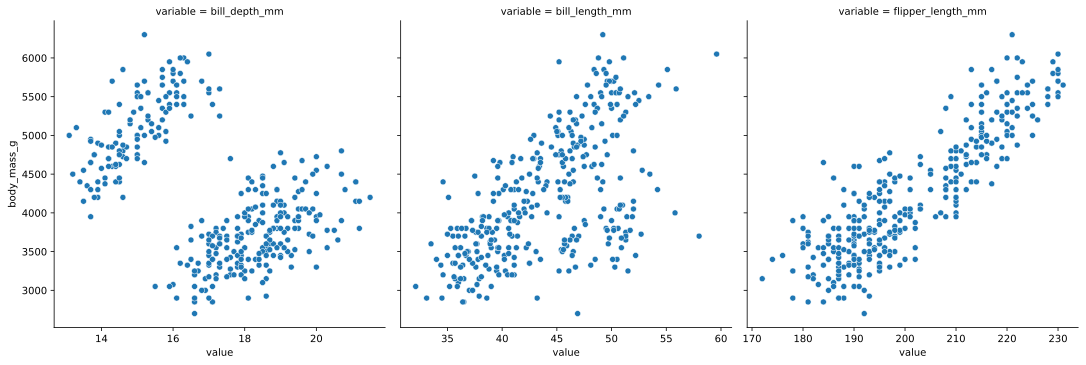

In [4]:
long = data.melt(id_vars=['body_mass_g'],
    value_vars=['bill_depth_mm', 'bill_length_mm', 'flipper_length_mm'])
sns.relplot(data=long, x='value', y='body_mass_g', col='variable',
    facet_kws={'sharex': False})

Body mass seems to correlate with **flipper length**. The longer the penguin flipper length, the heavier it is, generally speaking. Let's see whether we can predict penguin body mass using flipper length by modeling the relationship with linear regression: penguin flipper length will be the independent variable whilst penguin body mass will be the dependent variable.

We can analytically solve Linear Regression by minimizing the *Residual Sum-of-Squares* cost function:

$RSS(\beta) = (y - X \beta)^T (y - X \beta)$

In which $X$ is our *design matrix*. This loss function is also sometimes just referred to as "Ordinary Least Squares".

### Ordinary Least Squares
First, we must build our design matrix. The design matrix contains all explanatory variables with which we would like to predict $y$. To incorporate the data intercept we can include a bias constant of 1 in our design matrix. An alternative would be to first center our data such to get rid of the intercept entirely. We define the design matrix as follows.

In [5]:
def add_bias_term(X):
    b = np.ones((len(X), 1))
    X = np.hstack([b, X])
    return X
X_train = data_train[['flipper_length_mm']].values
X_train = add_bias_term(X_train)
Y_train = data_train[['body_mass_g']].values
X_train.shape, Y_train.shape

((255, 2), (255, 1))



 To now minimize our cost function we differentiate RSS with respect to $\beta$, giving us the following unique minimum:

$\hat{\beta} = (X^T X)^{-1} X^T Y$

In [6]:
β = lambda X, Y: np.linalg.pinv(X.T @ X) @ X.T @ Y
β_train = β(X_train, Y_train)
β_train

array([[-5781.51310866],
       [   49.72704083]])

Which results in the estimated least-squares coefficients given the training data. We can classify by simply multiplying our input data point with the found coefficient matrix: $\hat{y} = X \hat{\beta}$.

Let's see how well we did, quantitatively. We can do this by evaluating the Residual Sum-of-Squares on our observations given regression projection.

In [7]:
RSS = lambda X, Y, β: np.transpose(Y - X @ β) @ (Y - X @ β)
RSS(X_train, Y_train, β_train)

array([[41373462.44144496]])

An easier measurement would be to take the mean error over all samples, i.e. to compute the `MSE`.

In [8]:
MSE = lambda X, Y, β: (RSS(X, Y, β) / len(X)).item()
err_train = MSE(X_train, Y_train, β_train)
err_train

162248.872319392

We will also evaluate the MSE for our testing data:

In [9]:
X_test = data_test[['flipper_length_mm']].values
X_test = add_bias_term(X_test)
Y_test = data_test[['body_mass_g']].values
X_test.shape, Y_test.shape

((78, 2), (78, 1))

In [10]:
err_test = MSE(X_test, Y_test, β_train)
err_test

126389.96201089853

In [11]:
def predict(x_axis, β):
    x = np.linspace(x_axis.min(), x_axis.max())
    b = np.ones(len(x))
    X = np.vstack([b, x]).T
    ŷ = X @ β
    ŷ = ŷ.flatten()
    return pd.DataFrame({'x': x, 'y': ŷ})
ŷ = predict(data['flipper_length_mm'], β_train)
ŷ.shape

(50, 2)

Let's observe our fitted regression line onto the data:

Text(0.5, 1.0, 'Penguin Flipper length vs Body mass \nMSE: train = 1.62e+05, test = 1.26e+05')

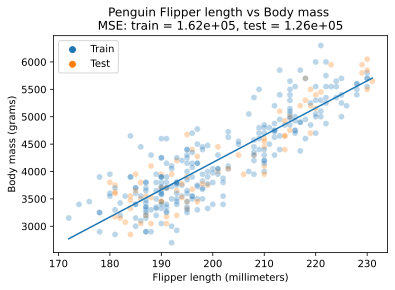

In [12]:
sns.scatterplot(data=data, x='flipper_length_mm', y='body_mass_g',
    hue='subset', alpha=0.3, hue_order=['Train', 'Test'])
sns.lineplot(data=ŷ, x='x', y='y')
plt.xlabel('Flipper length (millimeters)')
plt.ylabel('Body mass (grams)')
plt.title('Penguin Flipper length vs Body mass \n'+
    f'MSE: train = {err_train:.2e}, test = {err_test:.2e}')

### Ridge Regression
Let's see whether Ridge Regression is any good for this dataset, and explore what several different values of regularization strength do to our result.

In [279]:
import itertools
# n_sets = 100
# n_subsampled = np.repeat(len(data_train), n_sets) \
#     * np.linspace(1, 100, n_sets)//100
# n_subsampled = n_subsampled.astype(int)
n_subsampled = np.arange(2, len(data_train) + 1).astype(int)
alphas = np.array([0.0, 1.0, 5.0])
n_subsampled, alphas

(array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179

In [305]:
from sklearn.linear_model import Ridge

ridge_results = pd.DataFrame([])
experiments = itertools.product(n_subsampled, alphas)
for n, alpha in tqdm(list(experiments)):
    data_sampled = data_train.sample(n, random_state=34)
    X_train = data_sampled[['flipper_length_mm']].values
    X_train = add_bias_term(X_train)
    Y_train = data_sampled[['body_mass_g']].values

    model = Ridge(fit_intercept=False, alpha=alpha, solver='svd')
    model.fit(X_train, Y_train)
    β_ridge = np.expand_dims(model.coef_[0], axis=1)
    err_train = MSE(X_train, Y_train, β_ridge)
    err_test = MSE(X_test, Y_test, β_ridge)

    ridge_results = ridge_results.append({
        'MSE loss': err_train, 'Subset': 'Train', 'n': n, 'λ': alpha
    }, ignore_index=True)
    ridge_results = ridge_results.append({
        'MSE loss': err_test, 'Subset': 'Test', 'n': n, 'λ': alpha
    }, ignore_index=True)

  0%|          | 0/762 [00:00<?, ?it/s]

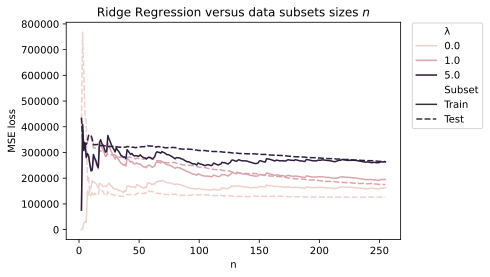

In [306]:
sns.lineplot(data=ridge_results, x='n', y='MSE loss', hue='λ', style='Subset')
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1.02))
plt.title('Ridge Regression versus data subsets sizes $n$')
plt.savefig('ridge-vs-loss.svg')

### Polynomial Regression
Let's also see what happens when we fit a more flexible model: polynomial regression - does the flexibility improve our results or does it only cause overfit?

((10, 2), (10, 1))

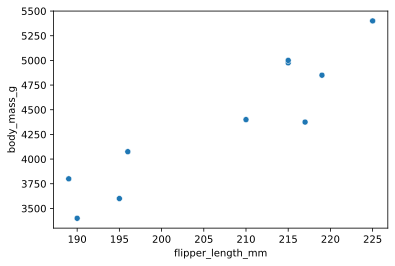

In [309]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

data_sampled = data_train.sample(10, random_state=917)
X_sampled = data_sampled[['flipper_length_mm']].values
X_sampled = add_bias_term(X_sampled)
Y_sampled = data_sampled[['body_mass_g']].values
sns.scatterplot(data=data_sampled, x='flipper_length_mm', y='body_mass_g')
X_sampled.shape, Y_sampled.shape

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Polynomial degree fits versus MSE losses')

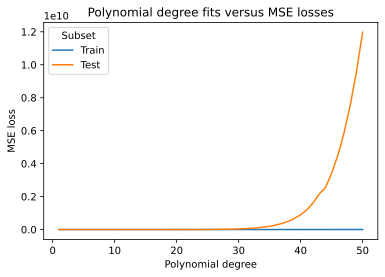

In [310]:
poly_results = pd.DataFrame([])
β_poly = None
coefs = []
degrees = list(range(1, 51))
for degree in tqdm(degrees):
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X_sampled)

    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, Y_sampled)
    β_poly = np.expand_dims(model.coef_[0], axis=1)
    coefs.append(β_poly)

    err_train = MSE(X_poly, Y_sampled, β_poly)
    err_test = MSE(poly.fit_transform(X_test), Y_test, β_poly)
    poly_results = poly_results.append({
        'MSE loss': err_train, 'Subset': 'Train', 'Polynomial degree': degree
    }, ignore_index=True)
    poly_results = poly_results.append({
        'MSE loss': err_test, 'Subset': 'Test', 'Polynomial degree': degree
    }, ignore_index=True)

def poly_interp(x_axis, β, poly):
    x = np.linspace(x_axis.min(), x_axis.max())
    b = np.ones(len(x))
    X = np.vstack([b, x]).T
    X = poly.fit_transform(X)
    ŷ = X @ β
    ŷ = ŷ.flatten()
    return pd.DataFrame({'x': x, 'y': ŷ})

sns.lineplot(data=poly_results, x='Polynomial degree', y='MSE loss',
    hue='Subset')
plt.title('Polynomial degree fits versus MSE losses')

In [313]:
folder = tempfile.mkdtemp()
print(f'Saving images to {folder}')

Saving images to /var/folders/34/923qqr696yz_ybx0dl171fn80000gn/T/tmpf4bwyhaf


0it [00:00, ?it/s]

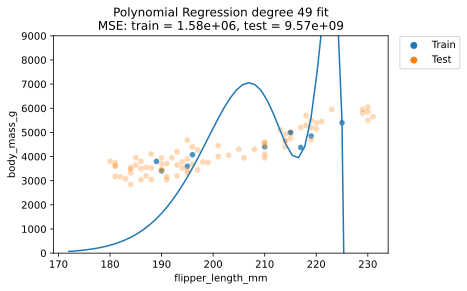

In [314]:
fig = plt.figure()
ax = fig.gca()
iterator = np.roll(degrees, shift=1)
for frame, degree in tqdm(enumerate(iterator), total=len(iterator)):
    ax.cla()
    poly = PolynomialFeatures(degree)
    ŷ = poly_interp(data['flipper_length_mm'], coefs[degree - 1], poly)
    sns.scatterplot(data=data_sampled, x='flipper_length_mm', y='body_mass_g',
        hue='subset', hue_order=['Train', 'Test'], ax=ax, alpha=0.8)
    sns.scatterplot(data=data_test, x='flipper_length_mm', y='body_mass_g',
        hue='subset', hue_order=['Train', 'Test'], ax=ax, legend=None,
        alpha=0.3)
    sns.lineplot(data=ŷ, x='x', y='y', ax=ax)
    plt.ylim(0, 9000)

    res = poly_results[poly_results['Polynomial degree'] == degree]
    err_train = res[res['Subset'] == 'Train']['MSE loss'].values.item()
    err_test = res[res['Subset'] == 'Test']['MSE loss'].values.item()
    plt.title(f'Polynomial Regression degree {degree:02} fit\n' +
    f'MSE: train = {err_train:.2e}, test = {err_test:.2e}')
    plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1.02))
    plt.savefig(f'{folder}/frame_{frame:02}.png')

In [315]:
!convert -background white -alpha remove -dispose Previous +antialias -delay 8 -layers OptimizePlus $folder/*.png ./images/polynomial-fit.gif

In [316]:
shutil.rmtree(folder)

NameError: name 'shutil' is not defined

### High-dimensional data: Analytic versus SGD solution
The dataset we fit the regression on was pretty easy - perhaps a drastic oversimplification in comparison to the real world. In the real world, datasets might be of very high dimensionality: think of images, speech, or a biomedical dataset storing DNA sequences.

So, let's simulate a high-dimensional situation, in which the amount of dimensions far outmatches the amount of dataset samples ($p \gg n$). We will simply copy the dataset columns and add some noise to them to make them different.

In [13]:
def noised_dataset(p_ε):
    """Adds p_ε noise dimensions to design matrices."""
    X_train = data_train[['flipper_length_mm']].values
    ε = np.random.normal(size=(len(X_train), p_ε))
    X_train = np.hstack([X_train, ε])
    X_train = add_bias_term(X_train)

    X_test = data_test[['flipper_length_mm']].values
    ε = np.random.normal(size=(len(X_test), p_ε))
    X_test = np.hstack([X_test, ε])
    X_test = add_bias_term(X_test)

    return X_train, X_test
Xbig_train, Xbig_test = noised_dataset(2000 - 2)
Xbig_train.shape, Xbig_test.shape

((255, 2000), (78, 2000))

We will write a little function to benchmark an estimator. Let's see how long our regular analytic fit takes.

In [14]:
def experiment(estimator, solver, X_train, X_test, Y_train, Y_test):
    start = time()
    coefs = estimator(X_train, Y_train)
    end = time()
    t = end - start
    mse_train = MSE(X_train, Y_train, coefs)
    mse_test = MSE(X_test, Y_test, coefs)
    n, p = X_train.shape
    return pd.DataFrame({
        'Loss':     [mse_train, mse_test],
        'Subset':   ['Train', 'Test'],
        'Time':     end - start,
        'Solver':   solver,
        'p':        p
    })

def define_estimator(estimator, name):
    return lambda *data: experiment(estimator, name, *data)

est_ana = define_estimator(β, 'Analytic')
res_ana = est_ana(Xbig_train, Xbig_test, Y_train, Y_test)
f'Linear Regression fit took {res_ana["Time"].values[0]} seconds'

'Linear Regression fit took 9.402719020843506 seconds'

Ouch. That took quite a while. Computing matrix inverses on large dimensional matrices is a very slow operation. Let's compare with the lower dimensional data approach by running each 10 times:

In [15]:
def n_experiments(estimator, *data, n=10):
    for i in range(n):
        yield estimator(*data)
        
exp_data = Xbig_train, Xbig_test, Y_train, Y_test
exp_ana = list(tqdm(n_experiments(est_ana, *exp_data, n=10), total=10))

exp_data = X_train, X_test, Y_train, Y_test
exp_ana_small = list(tqdm(n_experiments(est_ana, *exp_data, n=10), total=10))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Normal Equation fitting times\n(avg over 10 runs)')

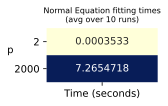

In [16]:
ana_res = pd.concat(exp_ana + exp_ana_small)
molten = pd.pivot_table(ana_res, values='Time', index=['p'])
molten = molten.rename(columns={'Time': 'Time (seconds)'})
f, ax = plt.subplots(figsize=(2, 1))
g = sns.heatmap(molten, annot=True, fmt='.7f', ax=ax, cbar=False, cmap="YlGnBu")
plt.setp(g.get_xticklabels(), rotation=0)
plt.setp(g.get_yticklabels(), rotation=0)
plt.ylabel('p',rotation=0)
plt.title('Normal Equation fitting times\n(avg over 10 runs)', fontsize=8)

Clear difference. But we can do faster - using a more approximate, iterative procedure: **Gradient Descent**. Gradient Descent works by computing the gradient of the cost function with respect to the model weights - such that we can then move in the opposite direction of the gradient in parameter space. We can again run a small experiment to benchmark the estimator runtime on the high-dimensional dataset:

In [17]:
sgdreg = SGDRegressor(alpha=0, n_iter_no_change=50, max_iter=20000, tol=1e-8,
    penalty='none', eta0=0.001, learning_rate='invscaling')

def sgd_coefs(X, Y):
    fit = sgdreg.fit(X[:, 1:], np.squeeze(Y))
    all_coefs = np.append(fit.intercept_, fit.coef_)
    all_coefs = np.expand_dims(all_coefs, axis=1)
    return all_coefs

est_sgd = define_estimator(sgd_coefs, 'SGD')
res_sgd = est_sgd(Xbig_train, Xbig_test, Y_train, Y_test)
f'SGD fit took {res_sgd["Time"].values[0]} seconds'

'SGD fit took 0.5250558853149414 seconds'

Text(0.5, 1.0, 'Penguin Flipper length vs Body mass \nSGD fit')

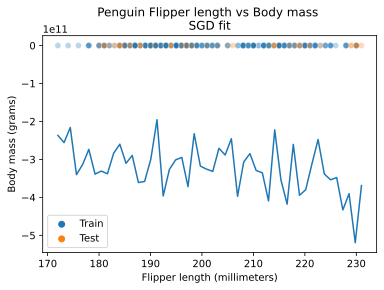

In [18]:
x = data['flipper_length_mm']
x = np.linspace(x.min(), x.max())
_, p = Xbig_train.shape
n = len(x)
ε = np.random.normal(size=(n, p - 2))
X = np.expand_dims(x, axis=1)
X = np.hstack([X, ε])
X = add_bias_term(X)

βsgd = sgd_coefs(Xbig_train, Y_train)
ŷ = np.squeeze(X @ βsgd)
ŷ = pd.DataFrame({'x': x, 'y': ŷ})

sns.scatterplot(data=data, x='flipper_length_mm', y='body_mass_g',
    hue='subset', alpha=0.3, hue_order=['Train', 'Test'])
sns.lineplot(data=ŷ, x='x', y='y')
plt.xlabel('Flipper length (millimeters)')
plt.ylabel('Body mass (grams)')
plt.title('Penguin Flipper length vs Body mass \n'+
    f'SGD fit')

Let's run the former benchmark multiple times to better compare the two approaches.

In [19]:
exp_data = Xbig_train, Xbig_test, Y_train, Y_test
exp_sgd = list(tqdm(n_experiments(est_sgd, *exp_data, n=10), total=10))

  0%|          | 0/10 [00:00<?, ?it/s]

We can observe SGD is much faster for such a high-dimensional dataset. Let's compare both in a plot.

Text(0.5, 1.0, 'MSE loss versus solver\np = 2000')

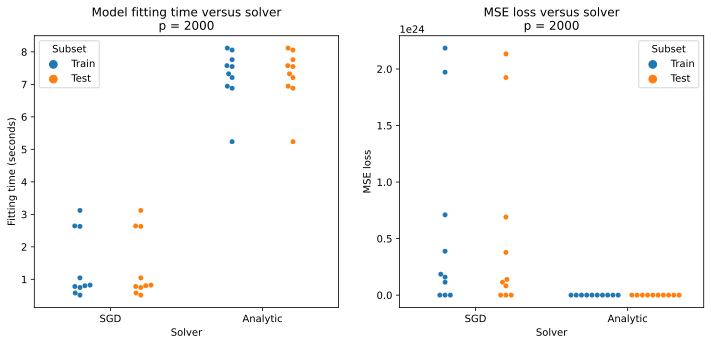

In [20]:
results_fixed_p = pd.concat(exp_sgd + exp_ana)
p = results_fixed_p['p'].unique().item()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.swarmplot(data=results_fixed_p, x='Solver', y='Time', hue='Subset',
              dodge=True, ax=ax1)
ax1.set_ylabel('Fitting time (seconds)')
ax1.set_title('Model fitting time versus solver\n' +
    f'p = {p}')

sns.swarmplot(data=results_fixed_p, x='Solver', y='Loss', hue='Subset',
              dodge=True, ax=ax2)
ax2.set_ylabel('MSE loss')
ax2.set_title('MSE loss versus solver\n' +
    f'p = {p}')

We can extend our benchmark even further and vary the amount of noise dimensions added. We'll conduct 10 benchmarks for each dimensionality configuration.

In [21]:
results_some_p = []
for p_ε in [0, 500, 1500]:
    Xbig_train, Xbig_test = noised_dataset(p_ε)
    exp_data = Xbig_train, Xbig_test, Y_train, Y_test
    exp1 = list(tqdm(n_experiments(est_sgd, *exp_data, n=10), total=10))
    exp2 = list(tqdm(n_experiments(est_ana, *exp_data, n=10), total=10))
    results_some_p = results_some_p + exp1
    results_some_p = results_some_p + exp2

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
results = pd.concat(results_some_p)

<AxesSubplot:xlabel='p', ylabel='Time'>

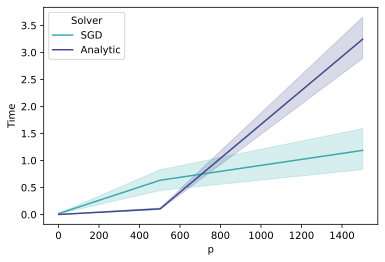

In [23]:
palette = sns.color_palette("mako_r", 2)
sns.lineplot(data=results, x='p', y='Time', hue='Solver', palette=palette)

Interesting results. Increasing amounts of dimensions seem to have an exponential effect on the analytic solution fitting time. Actually, this benchmark has been run on many more intermediate steps, on a more powerful computer. Let's check out those results.

Text(0.5, 1.0, 'Loss versus dataset dimensions')

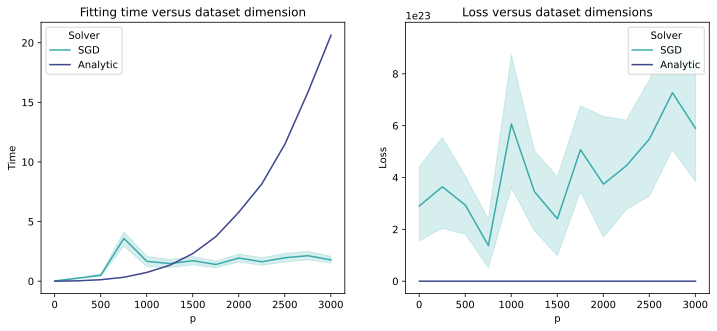

In [24]:
results_many_p = pd.read_csv('results/linear-regression.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data=results_many_p, x='p', y='Time', hue='Solver', palette=palette, ax=ax1)
ax1.set_title('Fitting time versus dataset dimension')

sns.lineplot(data=results_many_p, x='p', y='Loss', hue='Solver', palette=palette, ax=ax2)
ax2.set_title('Loss versus dataset dimensions')

Our analytic solution shows a clear exponential trend.

Indeed this is a game between time complexity and accuracy of our solutions - like we do see more often in the Machine Learning field. Given our dataset at hand and the time requirements of our solution, a ML practioner has to choose either of the solutions.

### Author
[Code](https://github.com/dunnkers/linear-regression-to-neural-networks) written by [Jeroen Overschie](https://dunnkers.com). MIT licensed.